#  Install package

In [59]:
# ! pip install pyvis
# ! pip install networkx

# Import package

In [60]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai


# Define Solution class
Please run the following cell to define the functions

In [61]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration 1: Resident living with hazardous wastes

## Input task and data desciption

In [62]:
TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilities.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
                  "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
                  "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
                 ]

task_name ='Resident_at_risk_counting'
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilities.
 
Data locations (each data is a node): 1. NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.
2. NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.
3. NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/N

## Get graph code from GPT API

In [63]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()
print()
print("Code to generate solution graph: \n")
print(solution.code_for_graph)

Geting reply...
Got reply.

Code to generate solution graph: 

import networkx as nx
G = nx.DiGraph()

# 1. Load hazardous waste site shapefile
G.add_node("haz_waste_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip", description="Hazardous waste facility shapefile URL")
G.add_node("load_haz_waste_shp", node_type="operation", description="Load hazardous waste facility shapefile")
G.add_edge("haz_waste_shp_url", "load_haz_waste_shp")
G.add_node("haz_waste_gdf", node_type="data", description="Hazardous waste facility GeoDataFrame")
G.add_edge("load_haz_waste_shp", "haz_waste_gdf")

# 2. Load NC tract boundary shapefile
G.add_node("nc_tract_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip", description="NC tract boundary shapefile URL")
G.add_node("load_nc_tract_shp", node_type="operation", description="Load NC tract boundary shapefile")
G

## Execute code to generate the solution graphto generate the solution graph

In [64]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

E:\Research\LLM-Geo\Resident_at_risk_counting.html


## Generate prompts and code for operations (functions)

In [65]:
# with open(r'F:\Research\LLM-Geo\Resident_at_risk_counting\Resident_at_risk_counting.pkl', 'rb') as f:
#     solution = pickle.load(f)

In [66]:
operations = solution.get_LLM_responses_for_operations()
solution.save_solution()

# all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
# print("All operation code: \n")
# print(all_operation_code_str)

1 / 6, load_haz_waste_shp
Geting reply...
Got reply.
2 / 6, load_nc_tract_shp
Geting reply...
Got reply.
3 / 6, load_nc_tract_pop_csv
Geting reply...
Got reply.
4 / 6, join_tract_pop
Geting reply...
Got reply.
5 / 6, calculate_pop_within_tracts
Geting reply...
Got reply.
6 / 6, generate_map
Geting reply...
Got reply.


## Generate prompts and code for assembly program

In [67]:
assembly_LLM_response = solution.get_LLM_assembly_response()
# solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

print("Assembly code: \n")
print(solution.code_for_assembly)

Geting reply...
Got reply.
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def main():
    # Load data
    haz_waste_gdf = load_haz_waste_shp()
    nc_tract_gdf = load_nc_tract_shp()
    nc_tract_pop_df = load_nc_tract_pop_csv()

    # Join tract and population data
    nc_tract_pop_gdf = join_tract_pop(nc_tract_gdf, nc_tract_pop_df)

    # Calculate total population within tracts with hazardous waste facilities
    total_pop_within_tracts = calculate_pop_within_tracts(haz_waste_gdf, nc_tract_pop_gdf)
    print("Total population within tracts containing hazardous waste facilities: ", total_pop_within_tracts)

    # Generate map
    map_file = generate_map(haz_waste_gdf, nc_tract_pop_gdf)
    print("Map file saved as:", map_file)

if __name__ == "__main__":
    main()
Assembly code: 

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def main():
    # Load data
    haz_waste_gdf = load_haz_waste_shp()
    nc_tract_gdf = load_nc_tra

## Execute assembly code

<string>:153: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
<string>:153: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


Total population within tracts containing hazardous waste facilities:  5688769
Map file saved as: population_map.png


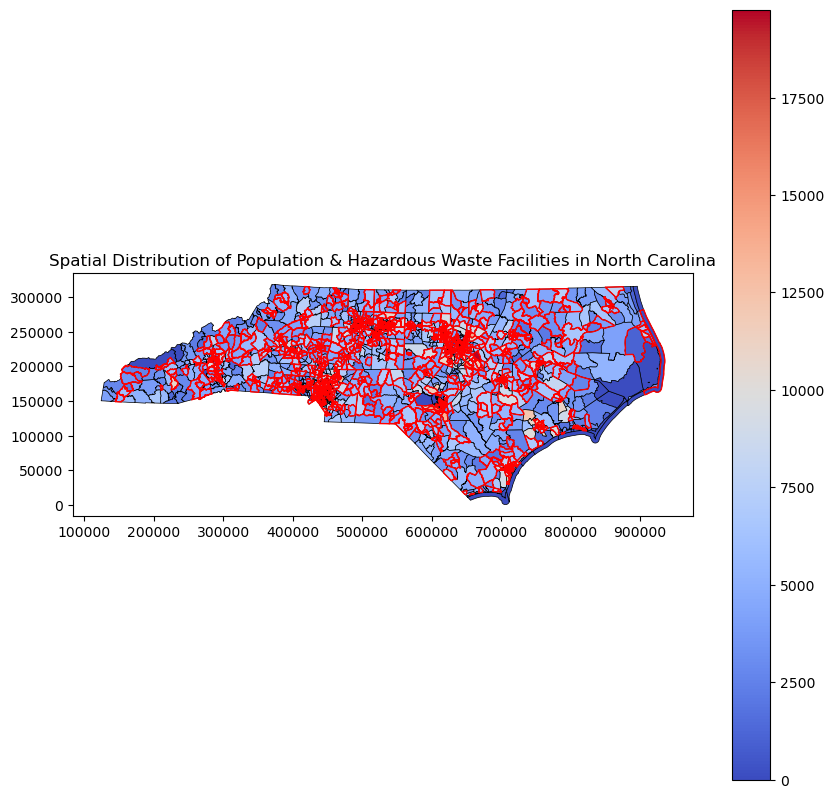

In [68]:
all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
all_code = all_operation_code_str + '\n' + solution.code_for_assembly
exec(all_code)

In [69]:
print(all_code)

import geopandas as gpd
import pandas as pd

def load_haz_waste_shp(haz_waste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip'):
    """
    Description: Load hazardous waste facility shapefile from a given URL
    haz_waste_shp_url: Hazardous waste facility shapefile URL
    return: Geopandas GeoDataFrame of hazardous waste facilities
    """
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)
    return haz_waste_gdf
import geopandas as gpd

def load_nc_tract_shp(nc_tract_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip'):
    """
    Description: Load NC tract boundary shapefile
    Input: 
        nc_tract_shp_url (str): URL of the tract shapefile
    Output: 
        nc_tract_gdf (GeoDataFrame): a GeoDataFrame containing the tract boundary data
    """
    nc_tract_gdf = gpd.read_file(nc_tract_shp_url)
    return nc_tract_gdf
def load_nc_tract_pop_csv(nc_tract_pop_csv_url='https://github